## 🙌 Inspiration and Credits
## ------------------------------

 This notebook draws inspiration from the exceptional work of mbanaei (@mbanaei) which can be found here: [Link to mbanaei's Notebook](https://www.kaggle.com/code/mbanaei/86-2-with-only-270k-articles).

## 🌟 Explore My Profile
## ------------------------------
 If you found this notebook valuable and insightful, I invite you to explore my Kaggle profile and other public projects for more exciting content and solutions:
 👉 [Visit my Kaggle Profile](https://www.kaggle.com/zulqarnainali) 👈

## 🙏 Thank You
# ------------------------------
 Your time and attention are greatly appreciated. If you found this work helpful or insightful, please consider giving it a thumbs-up to show your support and appreciation! 👍
## How to Use 🛠️
To use this notebook effectively, please follow these steps:

Ensure you have the competition data and environment set up.
Execute each cell sequentially to perform data preparation, feature engineering, model training, and prediction submission.
Customize and adapt the code as needed to improve model performance or experiment with different approaches.

Note: Make sure to replace any placeholder paths or configurations with your specific information.

In [3]:
# 📦 Import necessary libraries and modules for data manipulation and processing.
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from datasets import load_dataset, load_from_disk
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import LongformerTokenizer, LongformerForMultipleChoice
import transformers
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import unicodedata

# 📂 Import the "os" module for operating system-related functionality.
import os
import gc

In [48]:
# 🛑 Define a list of stop words to be used in text processing.
stop_words = ['each', 'you', 'the', 'use', 'used',
                  'where', 'themselves', 'nor', "it's", 'how', "don't", 'just', 'your',
                  'about', 'himself', 'with', "weren't", 'hers', "wouldn't", 'more', 'its', 'were',
                  'his', 'their', 'then', 'been', 'myself', 're', 'not',
                  'ours', 'will', 'needn', 'which', 'here', 'hadn', 'it', 'our', 'there', 'than',
                  'most', "couldn't", 'both', 'some', 'for', 'up', 'couldn', "that'll",
                  "she's", 'over', 'this', 'now', 'until', 'these', 'few', 'haven',
                  'of', 'wouldn', 'into', 'too', 'to', 'very', 'shan', 'before', 'the', 'they',
                  'between', "doesn't", 'are', 'was', 'out', 'we', 'me',
                  'after', 'has', "isn't", 'have', 'such', 'should', 'yourselves', 'or', 'during', 'herself',
                  'doing', 'in', "shouldn't", "won't", 'when', 'do', 'through', 'she',
                  'having', 'him', "haven't", 'against', 'itself', 'that',
                  'did', 'theirs', 'can', 'those',
                  'own', 'so', 'and', 'who', "you've", 'yourself', 'her', 'he', 'only',
                  'what', 'ourselves', 'again', 'had', "you'd", 'is', 'other',
                  'why', 'while', 'from', 'them', 'if', 'above', 'does', 'whom',
                  'yours', 'but', 'being', "wasn't", 'be',
                  "'", 'd', 'doesn', 'don', 'isn', 'll', 's', 'shouldn', 't', 've', 'wasn', 'weren', 'won']

option_to_index = {option: idx for idx, option in enumerate('ABCDE')}
index_to_option = {v: k for k,v in option_to_index.items()}



In [14]:
# def whoosh_retrieval(df_valid, search_engine):
    
#     corpus_df_valid = df_valid.apply(lambda row:
#                                      f'{row["prompt"]}\n{row["prompt"]}\n{row["prompt"]}\n{row["A"]}\n{row["B"]}\n{row["C"]}\n{row["D"]}\n{row["E"]}',
#                                      axis=1).values

#     top_per_query = 20

#     top_indices_array = []
#     top_values_array = []
#     for idx in tqdm(range(0, len(corpus_df_valid))):
#         all_results = search_engine.perform_search(corpus_df_valid[idx])
#         # temp_scores = (corpus_tf_idf * wiki_vectors.T).toarray()
#         top_results = all_results[:top_per_query]
#         chunk_top_indices = np.array([int(x['file_path']) for x in top_results])
#         chunk_top_values = np.array([result.score for result in top_results])
#         # chunk_top_values = temp_scores[np.arange(temp_scores.shape[0])[:, np.newaxis], chunk_top_indices]

#         top_indices_array.append(chunk_top_indices)
#         top_values_array.append(chunk_top_values)

#     merged_top_scores = top_values_array
#     articles_indices = top_indices_array
    
#     return articles_indices, merged_top_scores


In [4]:
# from whoosh.analysis import *
# from nltk.stem import *
# import nltk
# from IR_improved.IR_Q4_1_3 import CustomFilter
# nltk.data.path.append('./nltk_data')
# analyzer = RegexTokenizer() | StopFilter(stop_words) | LowercaseFilter() | CustomFilter(WordNetLemmatizer().lemmatize, 'v') | CustomFilter(LancasterStemmer().stem)


In [5]:
# WordNetLemmatizer().lemmatize('what is the name of the mechanism for plant to absorb sunlight')

'what is the name of the mechanism for plant to absorb sunlight'

In [189]:
# list(analyzer(value=u('Red Shift')))

[Token(positions=False, chars=False, stopped=False, boost=1.0, removestops=True, mode='', text='shift'),
 Token(positions=False, chars=False, stopped=False, boost=1.0, removestops=True, mode='', text='shift')]

In [146]:
# from nltk.stem import WordNetLemmatizer, LancasterStemmer
# nltk.data.path.append('./nltk_data')
# def nltk_preprocessor(x):
#     lemmatizer = WordNetLemmatizer()
#     stemmer = LancasterStemmer()
#     return ' '.join([stemmer.stem(lemmatizer.lemmatize(word, 'v')) for word in x.split()])

In [63]:
# 📄 Define the function SplitList to split a list into chunks of a specified size.

def SplitList(mylist, chunk_size):
    return [mylist[offs:offs+chunk_size] for offs in range(0, len(mylist), chunk_size)]

# 📄 Define the function get_relevant_documents_parsed to retrieve relevant documents for OpenBookQA.
def get_relevant_documents_parsed(df_valid):
    df_chunk_size = 600
    
    # Load the "all-paraphs-parsed-expanded" dataset from disk.
    paraphs_parsed_dataset = load_from_disk("../input/all-paraphs-parsed-expanded")
    
    # Process and modify the text data for retrieval.
    modified_texts = paraphs_parsed_dataset.map(lambda example:
                                             {'temp_text':
                                              f"{example['title']} {example['section']} {example['text']}".replace('\n', " ").replace("'", "")},
                                             num_proc=2)["temp_text"]
    
    all_articles_indices = []
    all_articles_values = []
    
    # Loop through the validation data in chunks.
    for idx in tqdm(range(0, df_valid.shape[0], df_chunk_size)):
        df_valid_ = df_valid.iloc[idx: idx+df_chunk_size]
    
        # Perform retrieval and store the results.
        articles_indices, merged_top_scores = retrieval(df_valid_, modified_texts)
        all_articles_indices.append(articles_indices)
        all_articles_values.append(merged_top_scores)
        
    article_indices_array = np.concatenate(all_articles_indices, axis=0)
    articles_values_array = np.concatenate(all_articles_values, axis=0).reshape(-1)
    
    top_per_query = article_indices_array.shape[1]
    
    # Flatten the retrieved articles data.
    articles_flatten = [(
                         articles_values_array[index],
                         paraphs_parsed_dataset[idx.item()]["title"],
                         paraphs_parsed_dataset[idx.item()]["text"],
                        )
                        for index,idx in enumerate(article_indices_array.reshape(-1))]
    
    # Split the flattened data into chunks.
    retrieved_articles = SplitList(articles_flatten, top_per_query)
    return retrieved_articles

# 📄 Define the function get_relevant_documents for retrieving relevant documents.
def get_relevant_documents(df_valid):

    df_chunk_size = 800
    
    # Load the "stem-wiki-cohere-no-emb" dataset from disk.
    dataset_name = "../input/stem-wiki-cohere-no-emb"
    cohere_dataset_filtered = load_from_disk(f"./{dataset_name}")
    
    # Process and modify the text data for retrieval.
    modified_texts = cohere_dataset_filtered.map(lambda example:
                                             {'temp_text':
                                              unicodedata.normalize("NFKD", f"{example['title']} {example['text']}").replace('"', "")},
                                             num_proc=2)["temp_text"]
    
    all_articles_indices = []
    all_articles_values = []
    
    # Loop through the validation data in chunks.
    for idx in tqdm(range(0, df_valid.shape[0], df_chunk_size)):
        df_valid_ = df_valid.iloc[idx: idx+df_chunk_size]
    
        # Perform retrieval and store the results.
        articles_indices, merged_top_scores = retrieval(df_valid_, modified_texts)
   
        all_articles_indices.append(articles_indices)
        all_articles_values.append(merged_top_scores)
        
    article_indices_array = np.concatenate(all_articles_indices, axis=0)
    articles_values_array = np.concatenate(all_articles_values, axis=0).reshape(-1)
    
    top_per_query = article_indices_array.shape[1]
    
    # Flatten the retrieved articles data.
    articles_flatten = [(
                         articles_values_array[index],
                         cohere_dataset_filtered[idx.item()]["title"],
                         unicodedata.normalize("NFKD", cohere_dataset_filtered[idx.item()]["text"]),
                        )
                        for index,idx in enumerate(article_indices_array.reshape(-1))]
    
    # Split the flattened data into chunks.
    retrieved_articles = SplitList(articles_flatten, top_per_query)
    return retrieved_articles

# 📄 Define the retrieval function to perform document retrieval.

def retrieval(df_valid, modified_texts, vectorizer=TfidfVectorizer):
    
    corpus_df_valid = df_valid.apply(lambda row:
                                     f'{row["prompt"]}\n{row["prompt"]}\n{row["prompt"]}\n{row["A"]}\n{row["B"]}\n{row["C"]}\n{row["D"]}\n{row["E"]}',
                                     axis=1).values
    transformer_corpus = df_valid.apply(lambda row:
                                        f'{row["prompt"]}\n{row["A"]}\n{row["B"]}\n{row["C"]}\n{row["D"]}\n{row["E"]}',
                                     axis=1).values
    
    # Create and fit the TF-IDF vectorizer.
    vectorizer1 = vectorizer(ngram_range=(1,2),
                            token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                            stop_words=stop_words)

    vectorizer1.fit(corpus_df_valid)
    vocab_df_valid = vectorizer1.get_feature_names_out()
    
    vectorizer = vectorizer(ngram_range=(1,2),
                            token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
                            stop_words=stop_words,
                            vocabulary=vocab_df_valid)

    vectorizer.fit(modified_texts[:500000])
    corpus_tf_idf = vectorizer.transform(corpus_df_valid)
    
    print(f"length of vectorizer vocab is {len(vectorizer.get_feature_names_out())}")

    chunk_size = 100000
    top_per_chunk = 10
    top_per_query = 10

    # top_per_chunk = 20
    # top_per_query = 20

    all_chunk_top_indices = []
    all_chunk_top_values = []

    for idx in tqdm(range(0, len(modified_texts), chunk_size)):
        wiki_vectors = vectorizer.transform(modified_texts[idx: idx+chunk_size])
        temp_scores = (corpus_tf_idf * wiki_vectors.T).toarray()
        chunk_top_indices = temp_scores.argpartition(-top_per_chunk, axis=1)[:, -top_per_chunk:]
        chunk_top_values = temp_scores[np.arange(temp_scores.shape[0])[:, np.newaxis], chunk_top_indices]

        all_chunk_top_indices.append(chunk_top_indices + idx)
        all_chunk_top_values.append(chunk_top_values)

    top_indices_array = np.concatenate(all_chunk_top_indices, axis=1)
    top_values_array = np.concatenate(all_chunk_top_values, axis=1)
    
    merged_top_scores = np.sort(top_values_array, axis=1)[:,-top_per_query:]
    merged_top_indices = top_values_array.argsort(axis=1)[:,-top_per_query:]
    articles_indices = top_indices_array[np.arange(top_indices_array.shape[0])[:, np.newaxis], merged_top_indices]


    for idx, (top_doc_id, query) in enumerate(zip(articles_indices, transformer_corpus)): 
        docs = [modified_texts[i] for i in top_doc_id]
        q_emb = sentModel.encode(query, convert_to_tensor=True, device='cuda', normalize_embeddings=True, )
        doc_emb = sentModel.encode(docs, convert_to_tensor=True, device='cuda', normalize_embeddings=True)
        scores = q_emb @ doc_emb.T
        top_idx = scores.argsort(descending=False).cpu().numpy()
        merged_top_scores[idx] = scores[top_idx].cpu().numpy()
        articles_indices[idx, :] = articles_indices[idx, top_idx] 

    return articles_indices, merged_top_scores

from functools import partial
# retrieval = partial(retrieval, vectorizer=partial(BM25, k1=1.6, b=0.75))

# i used this a bit differently than what it was originally written for
def prepare_answering_input(
    example,  # example that contains, context, question, and options
    tokenizer,  # longformer_tokenizer
    # max_length=3072,
    max_length=4096,

):
    context = example["context"].replace("\n", " ").strip()
    question = example["prompt"].replace("\n", " ").strip()
    options = [example[option].replace("\n", " ").strip() for option in "ABCDE"]
    c_5 = [context] * len(options)
    q_plus_o = [
        " " + tokenizer.bos_token + " " + question + " " + option for option in options
    ]
    # try:
    tokenized_example = tokenizer(
        c_5,
        q_plus_o,
        truncation="only_first",
        max_length=max_length,
    )
    # except:
    #     tokenized_example = tokenizer(
    #         c_5,
    #         q_plus_o,
    #         # truncation="only_first",
    #         max_length=max_length,
    #     )
    tokenized_example["label"] = option_to_index[example["answer"].strip()]
    return tokenized_example


In [66]:
# qid = 20
# [print(modified_texts[i]) for i  in new_articles_indices[qid]]
# print()
# [print(modified_texts[i]) for i  in articles_indices[qid]]
# transformer_corpus[qid]

Quasielastic neutron scattering The term quasielastic scattering was originally coined in nuclear physics. It was applied to thermal neutron scattering since the early 1960s, notably in an article by Leon van Hove and in a highly cited one by Pierre Gilles de Gennes.
Neutron spin echo Many inelastic studies that use normal time-of-flight (TOF) or backscattering spectrometers rely on the huge incoherent neutron scattering
Neutron scattering Neutron scattering is practiced at research reactors and spallation neutron sources that provide neutron radiation of varying intensities. Neutron diffraction (elastic scattering) techniques are used for analyzing structures; where inelastic neutron scattering is used in studying atomic vibrations and other excitations.
Small-angle neutron scattering Small-angle neutron scattering (SANS) is an experimental technique that uses elastic neutron scattering at small scattering angles to investigate the structure of various substances at a mesoscopic scale

'What is the Lamb-Mössbauer factor in physics?\nThe ratio of elastic to total incoherent neutron scattering, or the ratio of recoil-free to total nuclear resonant absorption in Mössbauer spectroscopy.\nThe ratio of elastic to total coherent neutron scattering, or the ratio of recoil-free to total nuclear resonant absorption in Mössbauer spectroscopy.\nThe ratio of elastic to total incoherent neutron scattering, or the ratio of recoil-free to total nuclear resonant absorption in X-ray scattering.\nThe ratio of coherent to total incoherent neutron scattering, or the ratio of recoil-free to total nuclear resonant absorption in X-ray scattering.\nThe ratio of coherent to total incoherent neutron scattering, or the ratio of recoil-free to total nuclear resonant absorption in Mössbauer spectroscopy.'

In [94]:
# 📄 Read the test data from the CSV file "test.csv" into a DataFrame named "df_valid".
# df_valid = pd.read_csv("../input/kaggle-llm-science-exam/test.csv")
df_valid = pd.read_csv("../input/kaggle-llm-science-exam/train.csv")
df_valid = pd.read_csv("../input/99k-context/valid_500_with_context2.csv")
IS_TESTING = True
if len(df_valid) == 200: 
  IS_TESTING = False
IS_TESTING = True


In [7]:
import gc

In [49]:
# 📄 Retrieve relevant documents for the test data using the "get_relevant_documents_parsed" function.
SIM_MODEL = '../input/sentence-transformers-222/all-MiniLM-L6-v2'
from sentence_transformers import SentenceTransformer
sentModel = SentenceTransformer(SIM_MODEL).cuda().eval()

retrieved_articles_parsed = get_relevant_documents_parsed(df_valid)

# ♻️ Perform garbage collection to free up memory.
gc.collect()

# 📄 Retrieve relevant documents for the test data using the "get_relevant_documents" function.
retrieved_articles = get_relevant_documents(df_valid)

# ♻️ Perform garbage collection to free up memory.
gc.collect()

del sentModel
gc.collect()
torch.cuda.empty_cache()  



  0%|          | 0/1 [00:00<?, ?it/s]

length of vectorizer vocab is 11174


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

length of vectorizer vocab is 11174


  0%|          | 0/28 [00:00<?, ?it/s]

## Models

In [84]:
from transformers import AutoTokenizer, AutoModelForMultipleChoice
from peft import LoraConfig, TaskType, get_peft_model
# tokenizer = AutoTokenizer.from_pretrained("../working/deberta-v3-large_checkpoints/16_512_v2/checkpoint-350")
# model = AutoModelForMultipleChoice.from_pretrained("../working/deberta-v3-large_checkpoints/16_512_v2/checkpoint-350").cuda()

# checkpoint_path = '/kaggle/input/jason-trained-models-v3-512/checkpoint-344/checkpoint-344'
# checkpoint_path = f'../working/deberta-v3-large_checkpoints/16_512_v2/checkpoint-350'
# checkpoint_path = f'../working/deberta-v3-large_checkpoints/16_512_v2/checkpoint-344'

models_dict = {
  'deberta_16_512_v2': {
    'checkpoint_path': f'../working/deberta-v3-large_checkpoints/16_512_v2/checkpoint-350',
    'weight': 0.2,
  },
  'deberta_18_512_v2': {
    'checkpoint_path': f'../working/deberta-v3-large_checkpoints/checkpoints_18_512/checkpoint-550',
    'weight': 0.6,
  },
  # 'reward_deberta_16_512_v2': {
  #   'checkpoint_path': f'../working/reward-model-deberta-v3-large-v2_checkpoints/16_512_v4/checkpoint-350',
  #   'weight': 0.3,
  # },
  # 'longformer': {
  #   'checkpoint_path': '../input/longformer_qa_model',
  #   'weight': 0.2,
  # },
  # 'deberta_new':{
  #   'checkpoint_path': '../working_new/deberta-v3-large_checkpoints/18_512_new/checkpoint-394',
  #   'weight': 0.4, # with 0.6 deberta_18_512_v2 985
  # },
  # 'deberta_new_1024':{
  #   'checkpoint_path': '../working_new/deberta_new_18_1024_checkpoint-200',
  #   'weight': 0.4, # with 0.6 deberta_18_512_v2 985
  # },
  'deberta_60k_1024':{
    'checkpoint_path': '../working_new/checkpoint-240',
    'weight': 0.4, # with 0.6 deberta_18_512_v2 985
  },
  'deberta_60k_1024_2':{
    'checkpoint_path': '../working_new/checkpoint-348',
    'weight': 0.4, # with 0.6 deberta_18_512_v2 985
  },
    'deberta_60k_786_3':{
    'checkpoint_path': '../working_new/checkpoint-344',
    'weight': 0.4, # with 0.6 deberta_18_512_v2 985
  },

}

# checkpoint_path = f'../working/deberta-v3-large_checkpoints/checkpoints_18_512/checkpoint-550'

def load_model(checkpoint_path, use_peft=True):
  if use_peft:
    peft_config = LoraConfig.from_pretrained(checkpoint_path, torch_dtype=torch.float16)
    model_weights = f'{checkpoint_path}/torch_model'
    model = AutoModelForMultipleChoice.from_pretrained(model_weights, 
                                                       device_map='cuda:0', 
                                                       torch_dtype=torch.float16)
    tokenizer_weights = checkpoint_path
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_weights)
    model = get_peft_model(model, peft_config)
    checkpoint = torch.load(f'{model_weights}/pytorch_model.bin')
    model.base_model.model.load_state_dict(checkpoint)
  else:
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    model = AutoModelForMultipleChoice.from_pretrained(checkpoint_path, 
                                                       device_map='cuda:0',
                                                       torch_dtype=torch.float16)

  model.eval().cuda().half()
  print('model loaded')
  return model, tokenizer


## Run inference

In [61]:
from util_openbook import DataCollatorForMultipleChoice
from torch.utils.data import DataLoader
from datasets import Dataset
import pickle


if 'answer' not in df_valid.columns:
    df_valid['answer'] = 'A'


In [85]:
# 📊 Initialize empty lists to store predictions and submit IDs.

if IS_TESTING:
    # 🔄 Loop through the test data.
    for model_name in models_dict:
        predictions = []
        submit_ids = []
        if 'deberta' in model_name:
            model, tokenizer = load_model(models_dict[model_name]['checkpoint_path'], use_peft=True)
        else:
            model, tokenizer = load_model(models_dict[model_name]['checkpoint_path'], use_peft=False)

        models_dict[model_name]['prob'] = []
        data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
        for index in tqdm(range(df_valid.shape[0])):
            
            columns = df_valid.iloc[index].values
            submit_ids.append(columns[0])
            question = columns[1]
            options = [columns[2], columns[3], columns[4], columns[5], columns[6]]
            
            answer = columns[7] if len(columns) == 8 else 'A'
            # 📜 Prepare two different contexts using retrieved articles.
            context1 = f"{retrieved_articles[index][-4][2]}\n{retrieved_articles[index][-3][2]}\n{retrieved_articles[index][-2][2]}\n{retrieved_articles[index][-1][2]}"
            context2 = f"{retrieved_articles_parsed[index][-3][2]}\n{retrieved_articles_parsed[index][-2][2]}\n{retrieved_articles_parsed[index][-1][2]}"
            
            # 📚 Prepare input for answering questions using the tokenizer.
            # inputs1 = prepare_answering_input(
            #     tokenizer=tokenizer, question=question,
            #     options=options, context=context1,
            # )
            # inputs2 = prepare_answering_input(
            #     tokenizer=tokenizer, question=question,
            #     options=options, context=context2,
            # )
            example1 = {
                "context": context1,
                "prompt": question,
                "answer": answer,
                **{ch: opt for ch, opt in zip(list("ABCDE"), options)},
            }
            example2 = {
                "context": context2,
                "prompt": question,
                "answer": answer,
                **{ch: opt for ch, opt in zip(list("ABCDE"), options)},
            }
            inputs1 = prepare_answering_input(
                example = example1,
                tokenizer=tokenizer,
            )
            # inputs1['label'] = 0
            inputs1 = data_collator([inputs1])
            inputs2 = prepare_answering_input(
                example = example2,
                tokenizer=tokenizer,
            )
            inputs2 = data_collator([inputs2])

            # 🚀 Make predictions using the Longformer model.
            with torch.no_grad():
                for k in inputs1.keys():
                    inputs1[k] = inputs1[k].cuda()
                outputs1 = model(**inputs1)    
                losses1 = -outputs1.logits[0].detach().cpu().numpy()
                probability1 = torch.softmax(torch.tensor(-losses1).float(), dim=-1)
                # del inputs1, losses1, outputs1
                # gc.collect()

            with torch.no_grad():
                for k in inputs2.keys():
                    inputs2[k] = inputs2[k].cuda()
                outputs2 = model(**inputs2)
                losses2 = -outputs2.logits[0].detach().cpu().numpy()
                probability2 = torch.softmax(torch.tensor(-losses2).float(), dim=-1)
                # del inputs2, losses2, outputs2
                # gc.collect()
                
            # 🧾 Calculate the combined probability.
            # probability_ = (probability1 + probability2) / 2 # 0.87, 96
            probability_ = (probability1**2 + probability2**2) / 2 # 0.87, 96

            # probability_ = probability1 * 0.4 + probability2 * 0.6 # 0.89, 95

            models_dict[model_name]['prob'].append(probability_)


            # predict = np.array(list("ABCDE"))[np.argsort(probability_)][-3:].tolist()[::-1]
            # predictions.append(predict)
            

        # 📄 Combine the predictions into a single string for submission.
        # predictions = [" ".join(i) for i in predictions]
        with open(f'{model_name}_prob.pkl', 'wb') as f:
            pickle.dump(models_dict[model_name]['prob'], f)
        del models_dict[model_name]['prob']
        del model, tokenizer
        gc.collect()
        torch.cuda.empty_cache()



Some weights of the model checkpoint at ../working/deberta-v3-large_checkpoints/16_512_v2/checkpoint-350/torch_model were not used when initializing DebertaV2ForMultipleChoice: ['deberta.encoder.layer.19.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.5.attention.output.dense.lora_A.default.weight', 'deberta.encoder.layer.15.attention.self.query_proj.lora_A.default.weight', 'deberta.encoder.layer.13.output.dense.lora_B.default.weight', 'deberta.encoder.layer.2.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.8.attention.self.value_proj.lora_A.default.weight', 'deberta.encoder.layer.22.attention.output.dense.lora_A.default.weight', 'deberta.encoder.layer.16.attention.output.dense.lora_A.default.weight', 'deberta.encoder.layer.5.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.0.attention.output.dense.lora_B.default.weight', 'deberta.encoder.layer.19.attention.self.key_proj.lora_A.default.weight', 'deberta.encoder.l

model loaded


  0%|          | 0/200 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some weights of the model checkpoint at ../working/deberta-v3-large_checkpoints/checkpoints_18_512/checkpoint-550/torch_model were not used when initializing DebertaV2ForMultipleChoice: ['deberta.encoder.layer.19.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.9.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.17.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.21.attention.self.query_proj.lora_B.default.weight', 'deberta.encoder.layer.15.attention.self.query_proj.lora_A.default.weight', 'deberta.encoder.layer.17.attention.self.query_proj.lora_A.default.weight', 'classifier.original_module.weight', 'deberta.encoder.layer.2.attention.self.value_proj.lora_B.default.weight', 'deberta.encode

model loaded


  0%|          | 0/200 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some weights of the model checkpoint at ../working_new/checkpoint-240/torch_model were not used when initializing DebertaV2ForMultipleChoice: ['deberta.encoder.layer.19.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.9.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.17.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.21.attention.self.query_proj.lora_B.default.weight', 'deberta.encoder.layer.15.attention.self.query_proj.lora_A.default.weight', 'deberta.encoder.layer.17.attention.self.query_proj.lora_A.default.weight', 'classifier.original_module.weight', 'deberta.encoder.layer.2.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.16.attention.self.value_proj.lora_B.

model loaded


  0%|          | 0/200 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some weights of the model checkpoint at ../working_new/checkpoint-348/torch_model were not used when initializing DebertaV2ForMultipleChoice: ['deberta.encoder.layer.19.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.9.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.17.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.21.attention.self.query_proj.lora_B.default.weight', 'deberta.encoder.layer.15.attention.self.query_proj.lora_A.default.weight', 'deberta.encoder.layer.17.attention.self.query_proj.lora_A.default.weight', 'classifier.original_module.weight', 'deberta.encoder.layer.2.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.16.attention.self.value_proj.lora_B.

model loaded


  0%|          | 0/200 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some weights of the model checkpoint at ../working_new/checkpoint-344/torch_model were not used when initializing DebertaV2ForMultipleChoice: ['deberta.encoder.layer.19.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.9.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.17.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.21.attention.self.query_proj.lora_B.default.weight', 'deberta.encoder.layer.15.attention.self.query_proj.lora_A.default.weight', 'deberta.encoder.layer.17.attention.self.query_proj.lora_A.default.weight', 'classifier.original_module.weight', 'deberta.encoder.layer.2.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.16.attention.self.value_proj.lora_B.

model loaded


  0%|          | 0/200 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [95]:
# 📊 Initialize empty lists to store predictions and submit IDs.

if IS_TESTING:
    # 🔄 Loop through the test data.
    for model_name in models_dict:
        predictions = []
        submit_ids = []
        if 'deberta' in model_name:
            model, tokenizer = load_model(models_dict[model_name]['checkpoint_path'], use_peft=True)
        else:
            model, tokenizer = load_model(models_dict[model_name]['checkpoint_path'], use_peft=False)

        models_dict[model_name]['prob'] = []
        data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
        for index in tqdm(range(df_valid.shape[0])):
            
            columns = df_valid.iloc[index].values
            submit_ids.append(columns[0])
            question = columns[0]
            options = [columns[2], columns[3],columns[4], columns[5], columns[6]]
            
            answer = columns[7]
            # 📜 Prepare two different contexts using retrieved articles.
            # context1 = f"{retrieved_articles[index][-4][2]}\n{retrieved_articles[index][-3][2]}\n{retrieved_articles[index][-2][2]}\n{retrieved_articles[index][-1][2]}"
            # context2 = f"{retrieved_articles_parsed[index][-3][2]}\n{retrieved_articles_parsed[index][-2][2]}\n{retrieved_articles_parsed[index][-1][2]}"
            context1 = columns[1]
            # 📚 Prepare input for answering questions using the tokenizer.
            # inputs1 = prepare_answering_input(
            #     tokenizer=tokenizer, question=question,
            #     options=options, context=context1,
            # )
            # inputs2 = prepare_answering_input(
            #     tokenizer=tokenizer, question=question,
            #     options=options, context=context2,
            # )
            example1 = {
                "context": context1,
                "prompt": question,
                "answer": answer,
                **{ch: opt for ch, opt in zip(list("ABCDE"), options)},
            }

            inputs1 = prepare_answering_input(
                example = example1,
                tokenizer=tokenizer,
            )
            # inputs1['label'] = 0
            inputs1 = data_collator([inputs1])


 
            with torch.no_grad():
                for k in inputs1.keys():
                    inputs1[k] = inputs1[k].cuda()
                outputs1 = model(**inputs1)
                losses1 = -outputs1.logits[0].detach().cpu().numpy()
                probability1 = torch.softmax(torch.tensor(-losses1).float(), dim=-1)
                
            # 🧾 Calculate the combined probability.
            # probability_ = (probability1 + probability2) / 2 # 0.87, 96
            probability_ = probability1

            # probability_ = probability1 * 0.4 + probability2 * 0.6 # 0.89, 95

            models_dict[model_name]['prob'].append(probability_)


            # predict = np.array(list("ABCDE"))[np.argsort(probability_)][-3:].tolist()[::-1]
            # predictions.append(predict)
            

        # 📄 Combine the predictions into a single string for submission.
        # predictions = [" ".join(i) for i in predictions]
        with open(f'{model_name}_prob.pkl', 'wb') as f:
            pickle.dump(models_dict[model_name]['prob'], f)
        del models_dict[model_name]['prob']
        del model, tokenizer
        gc.collect()
        torch.cuda.empty_cache()



Some weights of the model checkpoint at ../working/deberta-v3-large_checkpoints/16_512_v2/checkpoint-350/torch_model were not used when initializing DebertaV2ForMultipleChoice: ['deberta.encoder.layer.19.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.5.attention.output.dense.lora_A.default.weight', 'deberta.encoder.layer.15.attention.self.query_proj.lora_A.default.weight', 'deberta.encoder.layer.13.output.dense.lora_B.default.weight', 'deberta.encoder.layer.2.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.8.attention.self.value_proj.lora_A.default.weight', 'deberta.encoder.layer.22.attention.output.dense.lora_A.default.weight', 'deberta.encoder.layer.16.attention.output.dense.lora_A.default.weight', 'deberta.encoder.layer.5.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.0.attention.output.dense.lora_B.default.weight', 'deberta.encoder.layer.19.attention.self.key_proj.lora_A.default.weight', 'deberta.encoder.l

model loaded


  0%|          | 0/500 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some weights of the model checkpoint at ../working/deberta-v3-large_checkpoints/checkpoints_18_512/checkpoint-550/torch_model were not used when initializing DebertaV2ForMultipleChoice: ['deberta.encoder.layer.19.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.9.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.17.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.21.attention.self.query_proj.lora_B.default.weight', 'deberta.encoder.layer.15.attention.self.query_proj.lora_A.default.weight', 'deberta.encoder.layer.17.attention.self.query_proj.lora_A.default.weight', 'classifier.original_module.weight', 'deberta.encoder.layer.2.attention.self.value_proj.lora_B.default.weight', 'deberta.encode

model loaded


  0%|          | 0/500 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some weights of the model checkpoint at ../working_new/checkpoint-240/torch_model were not used when initializing DebertaV2ForMultipleChoice: ['deberta.encoder.layer.19.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.9.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.17.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.21.attention.self.query_proj.lora_B.default.weight', 'deberta.encoder.layer.15.attention.self.query_proj.lora_A.default.weight', 'deberta.encoder.layer.17.attention.self.query_proj.lora_A.default.weight', 'classifier.original_module.weight', 'deberta.encoder.layer.2.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.16.attention.self.value_proj.lora_B.

model loaded


  0%|          | 0/500 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some weights of the model checkpoint at ../working_new/checkpoint-348/torch_model were not used when initializing DebertaV2ForMultipleChoice: ['deberta.encoder.layer.19.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.9.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.17.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.21.attention.self.query_proj.lora_B.default.weight', 'deberta.encoder.layer.15.attention.self.query_proj.lora_A.default.weight', 'deberta.encoder.layer.17.attention.self.query_proj.lora_A.default.weight', 'classifier.original_module.weight', 'deberta.encoder.layer.2.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.16.attention.self.value_proj.lora_B.

model loaded


  0%|          | 0/500 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some weights of the model checkpoint at ../working_new/checkpoint-344/torch_model were not used when initializing DebertaV2ForMultipleChoice: ['deberta.encoder.layer.19.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.9.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.17.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.21.attention.self.query_proj.lora_B.default.weight', 'deberta.encoder.layer.15.attention.self.query_proj.lora_A.default.weight', 'deberta.encoder.layer.17.attention.self.query_proj.lora_A.default.weight', 'classifier.original_module.weight', 'deberta.encoder.layer.2.attention.self.value_proj.lora_B.default.weight', 'deberta.encoder.layer.16.attention.self.value_proj.lora_B.

model loaded


  0%|          | 0/500 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [86]:
import pickle
for model_name in models_dict:
  with open(f'{model_name}_prob.pkl', 'rb') as f:
      models_dict[model_name]['prob'] = pickle.load(f)
  print(f'{model_name} loaded')

deberta_16_512_v2 loaded
deberta_18_512_v2 loaded
deberta_60k_1024 loaded
deberta_60k_1024_2 loaded
deberta_60k_786_3 loaded


In [87]:
weights_dict = {n:{'weight':models_dict[n]['weight']} for n in models_dict}
import json
weights_dict =json.dumps(weights_dict,  indent=4)
print(weights_dict)

{
    "deberta_16_512_v2": {
        "weight": 0.2
    },
    "deberta_18_512_v2": {
        "weight": 0.6
    },
    "deberta_60k_1024": {
        "weight": 0.4
    },
    "deberta_60k_1024_2": {
        "weight": 0.4
    },
    "deberta_60k_786_3": {
        "weight": 0.4
    }
}


In [93]:
from collections import OrderedDict
weights_dict = {
    "deberta_16_512_v2": {
        "weight": 0
    },
    "deberta_18_512_v2": {
        "weight": 0
    },
    "deberta_60k_1024": {
        "weight": 0
    },
    "deberta_60k_1024_2": {
        "weight": 0.
    },
    "deberta_60k_786_3": {
        "weight": 1.
    }
}
weights_dict = OrderedDict(weights_dict)

for model_name in weights_dict:
  models_dict[model_name]['weight'] = weights_dict[model_name]['weight']

power = 1

final_probs = None
for model_name in weights_dict:
    prob_array = np.array(models_dict[model_name]['prob'])
    if final_probs is None:
        final_probs = prob_array **power * models_dict[model_name]['weight']
    else:
        final_probs += prob_array **power * models_dict[model_name]['weight']

final_predictions = []
for probability_ in final_probs:
    predict = np.array(list("ABCDE"))[np.argsort(probability_)][-3:].tolist()[::-1]
    final_predictions.append(' '.join(predict))

# https://www.kaggle.com/code/philippsinger/h2ogpt-perplexity-ranking
import numpy as np
def precision_at_k(r, k):
    """Precision at k"""
    assert k <= len(r)
    assert k != 0
    return sum(int(x) for x in r[:k]) / k

def MAP_at_k(predictions, true_items, k=3):
    """Score is mean average precision at k"""
    U = len(predictions)
    map_at_3 = 0.0
    for u in range(U):
        user_preds = predictions[u].split()
        user_true = true_items[u]
        user_results = [1 if item == user_true else 0 for item in user_preds]
        for i in range(min(len(user_preds), k)):
            map_at_3 += precision_at_k(user_results, i+1) * user_results[i]
    return map_at_3 / U

m = MAP_at_k(final_predictions, df_valid.answer.values, k=3)
print( 'CV MAP@3 =', m)

CV MAP@3 = 0.99


### Try weights


In [74]:
from itertools import combinations
n = 3
all_combs = combinations(range(12), n)
comb_results = {}
highest_m = []


from collections import OrderedDict
for comb in tqdm(list(all_combs)):
  new_comb = list(comb).copy()
  for _ in range(n):
    new_comb = new_comb[1:] + new_comb[:1]
    # i, j, k, l  = new_comb
    for nc,k in zip(new_comb,weights_dict.keys()):
        weights_dict[k]['weight'] = nc
    for model_name in weights_dict:
        models_dict[model_name]['weight'] = weights_dict[model_name]['weight']
    final_probs = None
    for model_name in models_dict:
        prob_array = np.array(models_dict[model_name]['prob'])
        if final_probs is None:
            final_probs = prob_array**power * models_dict[model_name]['weight']
        else:
            final_probs += prob_array**power * models_dict[model_name]['weight']

    final_predictions = []
    for probability_ in final_probs:
        predict = np.array(list("ABCDE"))[np.argsort(probability_)][-3:].tolist()[::-1]
        final_predictions.append(' '.join(predict))
    
    m = []
    for i in range(0, 3):
        m.append(MAP_at_k(final_predictions, df_valid.answer.values, i+1))
    comb_results[' '.join([str(_) for _ in new_comb])] = sum(m)
    if sum(m)>=sum(highest_m):
        # print(new_comb, m)
        highest_m = m
        
print(highest_m)

all_comb_mat = []
from collections import Counter
for comb in comb_results:
  if comb_results[comb] == sum(highest_m):
    comb_numbers = [int(x) for x in comb.split()]
    all_comb_mat.append(comb_numbers)

all_comb_mat = np.array(all_comb_mat)
print(len(all_comb_mat))

  0%|          | 0/220 [00:00<?, ?it/s]

[0.985, 0.9925, 0.9925]
21


In [96]:
all_comb_mat

array([[1, 2, 3, 4, 0],
       [0, 1, 2, 3, 4],
       [2, 3, 5, 0, 1],
       [2, 3, 6, 0, 1],
       [2, 3, 7, 0, 1],
       [2, 3, 8, 0, 1],
       [2, 3, 9, 0, 1],
       [1, 2, 4, 5, 0],
       [1, 2, 4, 6, 0],
       [2, 4, 6, 0, 1],
       [1, 2, 4, 7, 0],
       [2, 4, 7, 0, 1],
       [1, 2, 4, 8, 0],
       [2, 4, 8, 0, 1],
       [1, 2, 4, 9, 0],
       [2, 4, 9, 0, 1],
       [1, 2, 5, 6, 0],
       [1, 2, 5, 7, 0],
       [2, 5, 7, 0, 1],
       [1, 2, 5, 8, 0],
       [2, 5, 8, 0, 1],
       [1, 2, 5, 9, 0],
       [2, 5, 9, 0, 1],
       [1, 2, 6, 7, 0],
       [1, 2, 6, 8, 0],
       [2, 6, 8, 0, 1],
       [1, 2, 6, 9, 0],
       [2, 6, 9, 0, 1],
       [1, 2, 7, 8, 0],
       [1, 2, 7, 9, 0],
       [2, 7, 9, 0, 1],
       [1, 2, 8, 9, 0],
       [3, 4, 7, 0, 1],
       [3, 4, 8, 0, 1],
       [3, 4, 9, 0, 1],
       [1, 3, 5, 6, 0],
       [1, 3, 5, 7, 0],
       [1, 3, 5, 8, 0],
       [3, 5, 8, 0, 1],
       [1, 3, 5, 9, 0],
       [3, 5, 9, 0, 1],
       [1, 3, 6,

  0%|          | 0/3 [00:00<?, ?it/s]

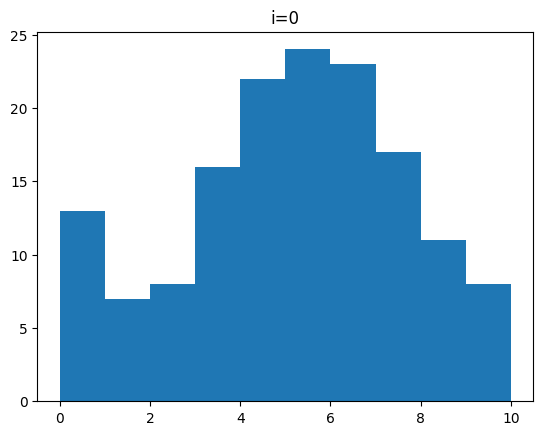

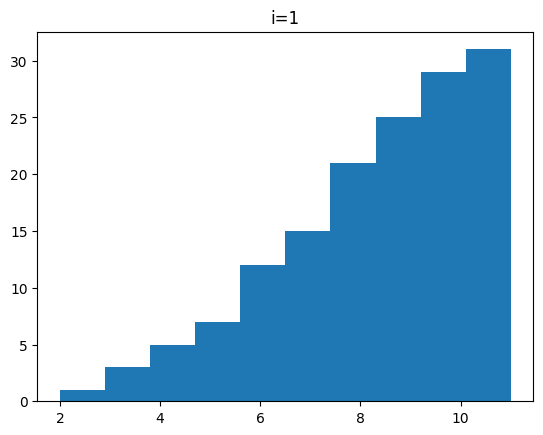

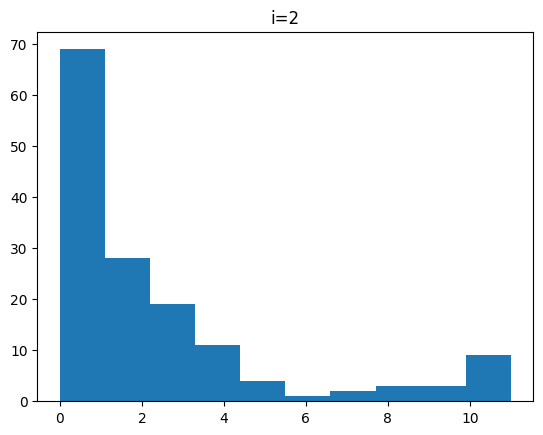

  0%|          | 0/3 [00:00<?, ?it/s]

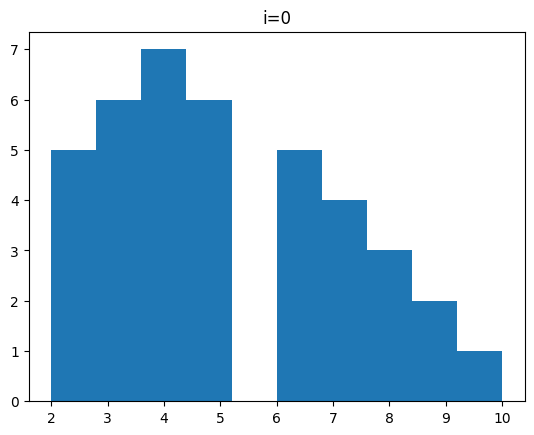

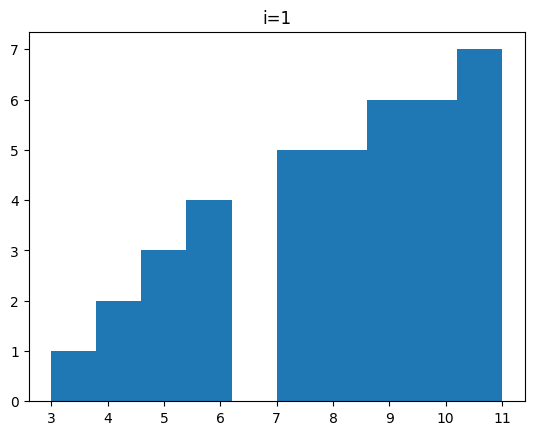

  0%|          | 0/3 [00:00<?, ?it/s]

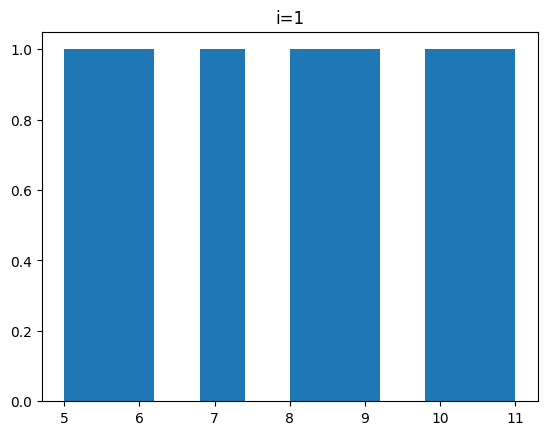

In [46]:

import matplotlib.pyplot as plt
posting_list = []
examined_i = []
examined_count = []
examined_i_value = []


for _ in range(all_comb_mat.shape[-1]):

  condition = np.ones(all_comb_mat.shape[0], dtype=bool)
  for ei, eival in zip(examined_i, examined_i_value):
    condition = condition & (all_comb_mat[:, ei] == eival)
  
  cur_all_comb_mat = all_comb_mat[condition]
  current_highest_i = -1
  current_highest_count = 0 
  for i in tqdm(range(cur_all_comb_mat.shape[-1])):
    if i in examined_i:
      continue
    plt.title(f'i={i}')
    plt.hist(cur_all_comb_mat[:, i])
    plt.show()
    counts = Counter(cur_all_comb_mat[:, i])
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    if counts[0][1] > current_highest_count:
      current_highest_count = counts[0][1]
      current_i_value = counts[0][0]
      current_highest_i = i

  examined_i.append(current_highest_i)
  examined_i_value.append(current_i_value)
  examined_count.append(current_highest_count)

In [47]:
all_list = list(zip(examined_i, examined_count, examined_i_value))
all_list = sorted(all_list, key=lambda x: x[0], reverse=False) 
all_list

[(0, 7, 4), (1, 1, 5), (2, 39, 1)]

In [68]:
# 📊 Create a DataFrame with submit IDs and predictions, and save it as a CSV file.
pd.DataFrame({'id': submit_ids, 'prediction': predictions}).to_csv('submission.csv', index=False)


## Explore More! 👀
Thank you for exploring this notebook! If you found this notebook insightful or if it helped you in any way, I invite you to explore more of my work on my profile.

👉 [Visit my Profile](https://www.kaggle.com/zulqarnainali) 👈

## Feedback and Gratitude 🙏
We value your feedback! Your insights and suggestions are essential for our continuous improvement. If you have any comments, questions, or ideas to share, please don't hesitate to reach out.

📬 Contact me via email: [zulqar445ali@gmail.com](mailto:zulqar445ali@gmail.com)

I would like to express our heartfelt gratitude for your time and engagement. Your support motivates us to create more valuable content.

## Happy coding and best of luck in your data science endeavors! 🚀
